In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2

#df_test = pd.read_csv('/home/yandex/igor/data_eyes/altyn_video_frames_orig_fps_crops_podium_const_all.csv', sep=';')
df_test = pd.read_csv('/home/yandex/igor/data_eyes/altyn_frames_last_1mln.csv', sep=';')

df_test

file     blink  \
0       /mnt/data/frames/altyn_original_fps_igor_origa...  0.000003   
1       /mnt/data/frames/altyn_original_fps_igor_origa...  0.000002   
2       /mnt/data/frames/altyn_original_fps_igor_origa...  0.000003   
3       /mnt/data/frames/altyn_original_fps_igor_origa...  0.000003   
4       /mnt/data/frames/altyn_original_fps_igor_origa...  0.000002   
...                                                   ...       ...   
957986  /mnt/data/frames/altyn_original_fps_igor_origa...  0.000003   
957987  /mnt/data/frames/altyn_original_fps_igor_origa...  0.000003   
957988  /mnt/data/frames/altyn_original_fps_igor_origa...  0.000017   
957989  /mnt/data/frames/altyn_original_fps_igor_origa...  0.000002   
957990  /mnt/data/frames/altyn_original_fps_igor_origa...  0.000010   

         bounding_box  bounding_box_center_x  bounding_box_center_x_deviation  \
0        13,24,99,110                     56                         0.000000   
1        14,26,98,110                     56                         0.000000   
2        13,27,97,111                     55                        -0.008929   
3        14,26,97,109                     55                        -0.004464   
4        15,27,97,109                     56                         0.000000   
...               ...                    ...                              ...   
957986  10,22,101,112                     55                        -0.004464   
957987   11,24,98,110                     54                        -0.013393   
957988   10,24,98,112                     54                        -0.017857   
957989   11,23,98,110                     54                        -0.013393   
957990    9,24,98,112                     53                        -0.022321   

        bounding_box_center_y  bounding_box_center_y_deviation  \
0                          67                         0.098214   
1                          68                         0.107143   
2                          69                         0.116071   
3                          67                         0.102679   
4                          68                         0.107143   
...                       ...                              ...   
957986                     67                         0.098214   
957987                     67                         0.098214   
957988                     68                         0.107143   
957989                     66                         0.093750   
957990                     68                         0.107143   

        bounding_box_height  bounding_box_height_relative  bounding_box_width  \
0                        86                      0.767857                  86   
1                        84                      0.750000                  84   
2                        84                      0.750000                  84   
3                        83                      0.741071                  83   
4                        82                      0.732143                  82   
...                     ...                           ...                 ...   
957986                   90                      0.803571                  91   
957987                   86                      0.767857                  87   
957988                   88                      0.785714                  88   
957989                   87                      0.776786                  87   
957990                   88                      0.785714                  89   

        ...  light_exposure  light_lighting  num_of_all_faces    object  \
0       ...        0.494661        0.097078                 1  0.000482   
1       ...        0.496488        0.138742                 1  0.000339   
2       ...        0.495625        0.116140                 1  0.000401   
3       ...        0.493907        0.088437                 1  0.000548   
4       ...        0.499860        0.095432                 1  0.000124   
...     ...

<AxesSubplot:>

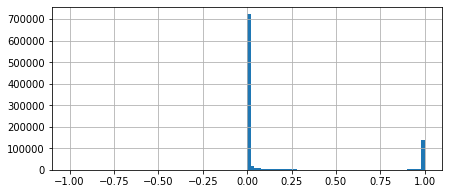

In [2]:
df_test['blink'].hist(bins = 100, figsize = (7, 3))

In [3]:
def select_data1(df_test_new, normalize = False, blink_zero=False, two_faces=True, podium=True):
    """
    light_exposure:
    <0.15 - очень темные
    >0.9 - очень светлые
    примерно [0.4, 0.6] - норма
    light_background
    >0.95 - яркий фон
    примерно [0.4, 0.6] - норма
    light_lighting
    >0.95 - сильно неравномерно освещено лицо
    примерно [0, 0.5] - норма
    face_brightness
    <0.3 - темные лица
    sharpness
    =0 - сильно размыто
    примерно >0.625 нормально
    left_right и up_down по модулю меньше 0.3
    object<0.9
    """

    if two_faces:
        df_test_new = df_test_new[df_test_new.const_left!=-1]
        df_test_new = df_test_new[df_test_new.const_right!=-1]

        df_test_new = df_test_new[df_test_new.const_left!=float('inf')]
        df_test_new = df_test_new[df_test_new.const_right!=float('inf')]


        #df_test_new = df_test_new[df_test_new.const_left<= 0.31]#0.4]
        #df_test_new = df_test_new[df_test_new.const_right<= 0.31]#0.4]

    if podium:
        df_test_new = df_test_new[df_test_new.light_exposure>0.15]
        df_test_new = df_test_new[df_test_new.light_exposure<0.9]
        df_test_new = df_test_new[df_test_new.light_background<0.95]
        df_test_new = df_test_new[df_test_new.light_lighting<0.95]
        df_test_new = df_test_new[df_test_new.object<0.9]
        df_test_new = df_test_new[df_test_new.face_brightness>0.3]
        df_test_new = df_test_new[df_test_new.sharpness>0.625]#0.625]
        
        df_test_new = df_test_new[abs(df_test_new.left_right)<0.3]
        df_test_new = df_test_new[abs(df_test_new.up_down)<0.3]

    if blink_zero:
        for index, row in df_test_new.iterrows():
            blink = row['blink']
            #const_left = row['const_left']
            #const_right = row['const_right']
            if blink > 0.95:
                df_test_new.loc[index, 'const_left'] = 0
                df_test_new.loc[index, 'const_right'] = 0

    if normalize:
        df_test_new['const_left']=df_test_new['const_left']-min(df_test_new.const_left)
        df_test_new['const_right']=df_test_new['const_right']-min(df_test_new.const_right)

        df_test_new['const_left']=(df_test_new['const_left']/max(df_test_new.const_left)*9).astype('int')
        df_test_new['const_right']=(df_test_new['const_right']/max(df_test_new.const_right)*9).astype('int')
    
    return df_test_new

df_test = select_data1(df_test, normalize = True, blink_zero=True, two_faces=True, podium=True)
def append_ext(fn):
    return fn.split('/')[-2]
df_test['person_id'] = df_test['file'].apply(append_ext)
df_test


file         blink  \
1       /mnt/data/frames/altyn_original_fps_igor_origa...  2.345916e-06   
2       /mnt/data/frames/altyn_original_fps_igor_origa...  2.975947e-06   
3       /mnt/data/frames/altyn_original_fps_igor_origa...  3.496734e-06   
5       /mnt/data/frames/altyn_original_fps_igor_origa...  1.095206e-05   
6       /mnt/data/frames/altyn_original_fps_igor_origa...  6.993753e-06   
...                                                   ...           ...   
957909  /mnt/data/frames/altyn_original_fps_igor_origa...  8.323333e-07   
957910  /mnt/data/frames/altyn_original_fps_igor_origa...  4.200743e-07   
957911  /mnt/data/frames/altyn_original_fps_igor_origa...  7.733055e-07   
957912  /mnt/data/frames/altyn_original_fps_igor_origa...  4.946193e-07   
957913  /mnt/data/frames/altyn_original_fps_igor_origa...  1.140787e-06   

        bounding_box  bounding_box_center_x  bounding_box_center_x_deviation  \
1       14,26,98,110                     56                         0.000000   
2       13,27,97,111                     55                        -0.008929   
3       14,26,97,109                     55                        -0.004464   
5       13,28,95,110                     54                        -0.017857   
6       14,26,97,109                     55                        -0.004464   
...              ...                    ...                              ...   
957909  4,16,109,112                     56                         0.004464   
957910  4,15,111,112                     57                         0.013393   
957911  4,16,108,112                     56                         0.000000   
957912  5,11,110,112                     57                         0.013393   
957913  3,15,109,112                     56                         0.000000   

        bounding_box_center_y  bounding_box_center_y_deviation  \
1                          68                         0.107143   
2                          69                         0.116071   
3                          67                         0.102679   
5                          69                         0.116071   
6                          67                         0.102679   
...                       ...                              ...   
957909                     64                         0.071429   
957910                     63                         0.066964   
957911                     64                         0.071429   
957912                     61                         0.049107   
957913                     63                         0.066964   

        bounding_box_height  bounding_box_height_relative  bounding_box_width  \
1                        84                      0.750000                  84   
2                        84                      0.750000                  84   
3                        83                      0.741071                  83   
5                        82                      0.732143                  82   
6                        83                      0.741071                  83   
...                     ...                           ...                 ...   
957909                   96                      0.857143                 105   
957910                   97                      0.866071                 107   
957911                   96                      0.857143                 104   
957912                  101                      0.901786                 105   
957913                   97                      0.866071                 106   

        ...  light_lighting  num_of_all_faces        object sharpness  \
1       ...        0.138742                 1  3.388613e-04    0.6875   
2       ...        0.116140                 1  4.005799e-04    0.7500   
3       ...        0.088437                 1  5.479222e-04    0.6875   
5       ...        0.182376                 1  2.567185e-03    0.6875   
6       ...        0.082775                 1  3.169638e-04 

In [4]:
for index, row in df_test[:1].iterrows():
    file = row['file']
    print(file.split('/')[-2])

445493eb-d0fa-4670-b785-bb3d2e10082d


In [5]:
df_test['person_id'].value_counts()

ff5c6936-0887-4711-92cb-10c8dd9aee76    173
4cb4995a-6e2a-41bb-96c3-2ebcfe8f1e0f    169
56910f11-9b58-4bbd-9242-0323703ea0ea    165
5475183d-6587-41a2-be3b-c8b55dd1a1c3    164
62d4d1ae-9851-48ec-816f-a77f4f7d7a27    163
                                       ... 
47f013db-df47-43c5-9bf3-2379d36aaa15      1
9a403c7f-6201-47ac-84ab-c1c0d6d7b6b2      1
5fc9b602-6af7-4eb8-a459-c9869daf4a22      1
b658e234-d746-4b3d-af26-e8d012777b14      1
80bd273b-a2b9-4d41-b0e7-985195290d02      1
Name: person_id, Length: 10241, dtype: int64

In [6]:
df_test_new = pd.read_csv('/home/yandex/igor/data_eyes/altyn_frames_last_1mln_sep_norm.csv', sep=';')
#df_test_new = select_data1(df_test_new, normalize = False, blink_zero=True, two_faces=False, podium=False)
df_test_new['const_left']=(df_test_new['const_left']*9).astype('int')
df_test_new['const_right']=(df_test_new['const_right']*9).astype('int')
df_test_new

file         blink  \
0       /mnt/data/frames/altyn_original_fps_igor_origa...  2.345916e-06   
1       /mnt/data/frames/altyn_original_fps_igor_origa...  2.975947e-06   
2       /mnt/data/frames/altyn_original_fps_igor_origa...  3.496734e-06   
3       /mnt/data/frames/altyn_original_fps_igor_origa...  1.095206e-05   
4       /mnt/data/frames/altyn_original_fps_igor_origa...  6.993753e-06   
...                                                   ...           ...   
714976  /mnt/data/frames/altyn_original_fps_igor_origa...  8.323333e-07   
714977  /mnt/data/frames/altyn_original_fps_igor_origa...  4.200743e-07   
714978  /mnt/data/frames/altyn_original_fps_igor_origa...  7.733055e-07   
714979  /mnt/data/frames/altyn_original_fps_igor_origa...  4.946193e-07   
714980  /mnt/data/frames/altyn_original_fps_igor_origa...  1.140787e-06   

        bounding_box  bounding_box_center_x  bounding_box_center_x_deviation  \
0       14,26,98,110                     56                         0.000000   
1       13,27,97,111                     55                        -0.008929   
2       14,26,97,109                     55                        -0.004464   
3       13,28,95,110                     54                        -0.017857   
4       14,26,97,109                     55                        -0.004464   
...              ...                    ...                              ...   
714976  4,16,109,112                     56                         0.004464   
714977  4,15,111,112                     57                         0.013393   
714978  4,16,108,112                     56                         0.000000   
714979  5,11,110,112                     57                         0.013393   
714980  3,15,109,112                     56                         0.000000   

        bounding_box_center_y  bounding_box_center_y_deviation  \
0                          68                         0.107143   
1                          69                         0.116071   
2                          67                         0.102679   
3                          69                         0.116071   
4                          67                         0.102679   
...                       ...                              ...   
714976                     64                         0.071429   
714977                     63                         0.066964   
714978                     64                         0.071429   
714979                     61                         0.049107   
714980                     63                         0.066964   

        bounding_box_height  bounding_box_height_relative  bounding_box_width  \
0                        84                      0.750000                  84   
1                        84                      0.750000                  84   
2                        83                      0.741071                  83   
3                        82                      0.732143                  82   
4                        83                      0.741071                  83   
...                     ...                           ...                 ...   
714976                   96                      0.857143                 105   
714977                   97                      0.866071                 107   
714978                   96                      0.857143                 104   
714979                  101                      0.901786                 105   
714980                   97                      0.866071                 106   

        ...  light_lighting  num_of_all_faces        object sharpness  \
0       ...        0.138742                 1  3.388613e-04    0.6875   
1       ...        0.116140                 1  4.005799e-04    0.7500   
2       ...        0.088437                 1  5.479222e-04    0.6875   
3       ...        0.182376                 1  2.567185e-03    0.6875   
4       ...        0.082775                 1  3.169638e-04 

<AxesSubplot:>

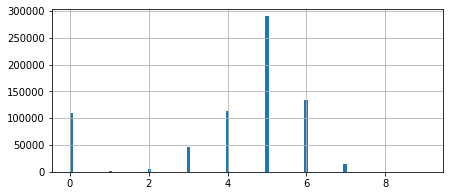

In [7]:
df_test['const_left'].hist(bins = 100, figsize = (7, 3))

In [8]:
df_test['const_left'].value_counts()

5    289902
6    134781
4    112643
0    108844
3     46508
7     14865
2      5961
1      1300
8       175
9         2
Name: const_left, dtype: int64

<AxesSubplot:>

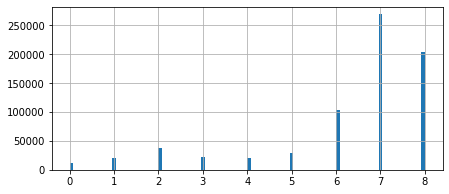

In [9]:
df_test_new['const_left'].hist(bins = 100, figsize = (7, 3))

In [10]:
df_test_new['const_left'].value_counts()

7    268495
8    203934
6    103433
2     36893
5     28186
3     22497
4     20663
1     19839
0     11041
Name: const_left, dtype: int64

In [11]:
"""for index, row in df_test_new.iterrows():
    blink = row['blink']
    #const_left = row['const_left']
    #const_right = row['const_right']
    if blink < 0.05:
        df_test_new.loc[index, 'const_left'] = 9
        df_test_new.loc[index, 'const_right'] = 9"""

"for index, row in df_test_new.iterrows():\n    blink = row['blink']\n    #const_left = row['const_left']\n    #const_right = row['const_right']\n    if blink < 0.05:\n        df_test_new.loc[index, 'const_left'] = 9\n        df_test_new.loc[index, 'const_right'] = 9"

In [12]:
df_test_new['const_left'].value_counts()

7    268495
8    203934
6    103433
2     36893
5     28186
3     22497
4     20663
1     19839
0     11041
Name: const_left, dtype: int64

<AxesSubplot:>

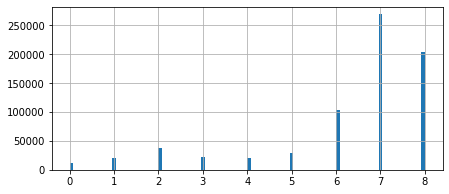

In [13]:
df_test_new['const_left'].hist(bins = 100, figsize = (7, 3))

In [14]:
df_test_new['person_id'].value_counts()

ff5c6936-0887-4711-92cb-10c8dd9aee76    173
4cb4995a-6e2a-41bb-96c3-2ebcfe8f1e0f    169
56910f11-9b58-4bbd-9242-0323703ea0ea    165
5475183d-6587-41a2-be3b-c8b55dd1a1c3    164
62d4d1ae-9851-48ec-816f-a77f4f7d7a27    163
                                       ... 
47f013db-df47-43c5-9bf3-2379d36aaa15      1
9a403c7f-6201-47ac-84ab-c1c0d6d7b6b2      1
5fc9b602-6af7-4eb8-a459-c9869daf4a22      1
b658e234-d746-4b3d-af26-e8d012777b14      1
80bd273b-a2b9-4d41-b0e7-985195290d02      1
Name: person_id, Length: 10241, dtype: int64

In [19]:
def append_ext(fn):
    return fn.split('/')[-1][:-4]
df_test_new['frame_num'] = df_test_new['file'].apply(append_ext)
df_test_new

file         blink  \
0       /mnt/data/frames/altyn_original_fps_igor_origa...  2.345916e-06   
1       /mnt/data/frames/altyn_original_fps_igor_origa...  2.975947e-06   
2       /mnt/data/frames/altyn_original_fps_igor_origa...  3.496734e-06   
3       /mnt/data/frames/altyn_original_fps_igor_origa...  1.095206e-05   
4       /mnt/data/frames/altyn_original_fps_igor_origa...  6.993753e-06   
...                                                   ...           ...   
714976  /mnt/data/frames/altyn_original_fps_igor_origa...  8.323333e-07   
714977  /mnt/data/frames/altyn_original_fps_igor_origa...  4.200743e-07   
714978  /mnt/data/frames/altyn_original_fps_igor_origa...  7.733055e-07   
714979  /mnt/data/frames/altyn_original_fps_igor_origa...  4.946193e-07   
714980  /mnt/data/frames/altyn_original_fps_igor_origa...  1.140787e-06   

        bounding_box  bounding_box_center_x  bounding_box_center_x_deviation  \
0       14,26,98,110                     56                         0.000000   
1       13,27,97,111                     55                        -0.008929   
2       14,26,97,109                     55                        -0.004464   
3       13,28,95,110                     54                        -0.017857   
4       14,26,97,109                     55                        -0.004464   
...              ...                    ...                              ...   
714976  4,16,109,112                     56                         0.004464   
714977  4,15,111,112                     57                         0.013393   
714978  4,16,108,112                     56                         0.000000   
714979  5,11,110,112                     57                         0.013393   
714980  3,15,109,112                     56                         0.000000   

        bounding_box_center_y  bounding_box_center_y_deviation  \
0                          68                         0.107143   
1                          69                         0.116071   
2                          67                         0.102679   
3                          69                         0.116071   
4                          67                         0.102679   
...                       ...                              ...   
714976                     64                         0.071429   
714977                     63                         0.066964   
714978                     64                         0.071429   
714979                     61                         0.049107   
714980                     63                         0.066964   

        bounding_box_height  bounding_box_height_relative  bounding_box_width  \
0                        84                      0.750000                  84   
1                        84                      0.750000                  84   
2                        83                      0.741071                  83   
3                        82                      0.732143                  82   
4                        83                      0.741071                  83   
...                     ...                           ...                 ...   
714976                   96                      0.857143                 105   
714977                   97                      0.866071                 107   
714978                   96                      0.857143                 104   
714979                  101                      0.901786                 105   
714980                   97                      0.866071                 106   

        ...  num_of_all_faces        object  sharpness     smile   up_down  \
0       ...                 1  3.388613e-04     0.6875  0.000292  0.214286   
1       ...                 1  4.005799e-04     0.7500  0.000337  0.214286   
2       ...                 1  5.479222e-04     0.6875  0.000237  0.228916   
3       ...                 1  2.567185e-03     0.6875  0.000369  0.219512   
4       ...                 1  3.16

In [42]:
for i,row in df_test_new[df_test_new['person_id']=='62d4d1ae-9851-48ec-816f-a77f4f7d7a27'].iterrows():
    if row['file']=='/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0059.jpg':
        print(row)

file                               /mnt/data/frames/altyn_original_fps_igor_origa...
blink                                                                        0.44971
bounding_box                                                           15,18,106,109
bounding_box_center_x                                                             60
bounding_box_center_x_deviation                                             0.040179
bounding_box_center_y                                                             63
bounding_box_center_y_deviation                                             0.066964
bounding_box_height                                                               91
bounding_box_height_relative                                                  0.8125
bounding_box_width                                                                91
bounding_box_width_relative                                                   0.8125
confidence                                                       

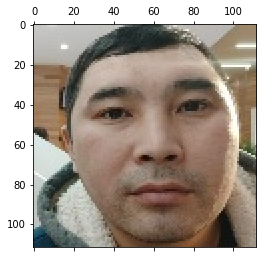

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0163.jpg
confidence =  0.8695721
blink =  5.9979504e-07
const_left =  6
const_right =  7




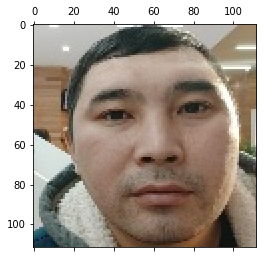

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0162.jpg
confidence =  0.9164217
blink =  3.9831357e-07
const_left =  6
const_right =  8




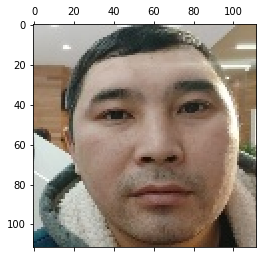

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0161.jpg
confidence =  0.8744338
blink =  4.4674783e-07
const_left =  6
const_right =  7




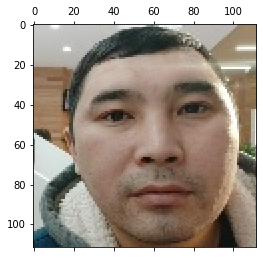

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0160.jpg
confidence =  0.9156881
blink =  3.9242977e-07
const_left =  6
const_right =  7




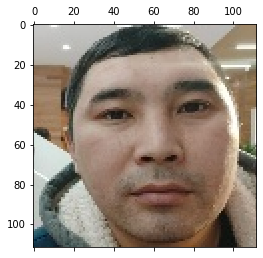

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0159.jpg
confidence =  0.8715406
blink =  6.477072e-07
const_left =  6
const_right =  6




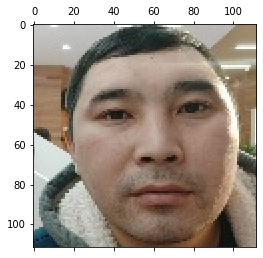

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0158.jpg
confidence =  0.90654176
blink =  4.2531275e-07
const_left =  5
const_right =  7




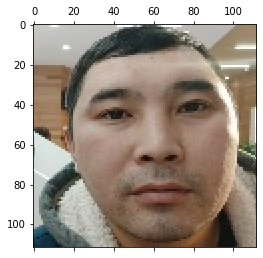

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0157.jpg
confidence =  0.86509264
blink =  1.2873292e-06
const_left =  6
const_right =  6




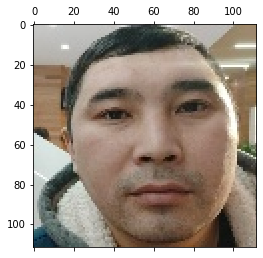

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0156.jpg
confidence =  0.8577988
blink =  8.905828e-07
const_left =  6
const_right =  7




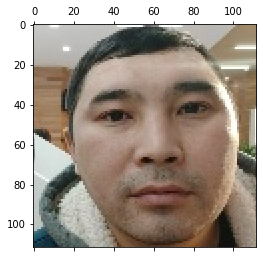

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0155.jpg
confidence =  0.8679509
blink =  7.5203945e-07
const_left =  6
const_right =  7




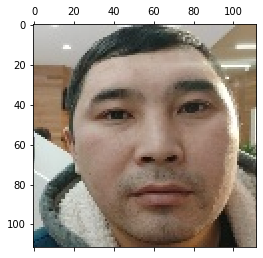

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0154.jpg
confidence =  0.8970149
blink =  4.4459546e-07
const_left =  6
const_right =  7




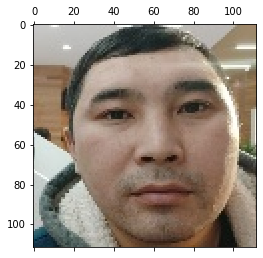

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0153.jpg
confidence =  0.87733066
blink =  7.4559586e-07
const_left =  6
const_right =  7




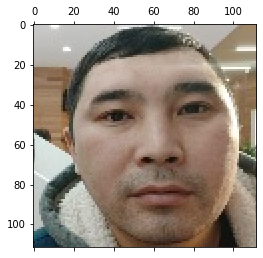

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0152.jpg
confidence =  0.91319364
blink =  4.835584e-07
const_left =  6
const_right =  7




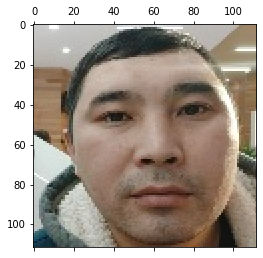

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0151.jpg
confidence =  0.9149812
blink =  1.1296985e-06
const_left =  5
const_right =  7




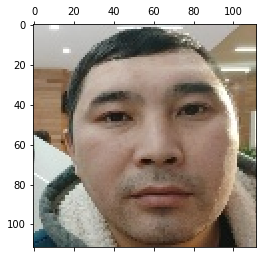

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0150.jpg
confidence =  0.92213565
blink =  7.405447e-07
const_left =  6
const_right =  6




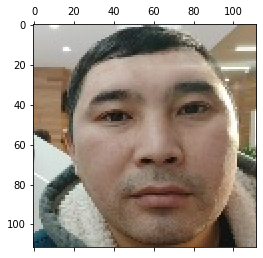

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0149.jpg
confidence =  0.9215636
blink =  4.9514694e-07
const_left =  6
const_right =  7




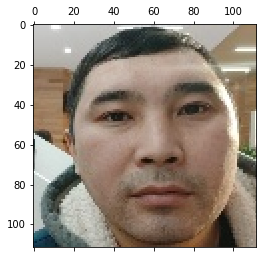

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0148.jpg
confidence =  0.89189637
blink =  1.2078183e-06
const_left =  6
const_right =  6




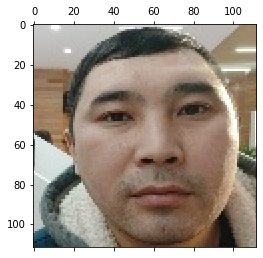

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0147.jpg
confidence =  0.9096225
blink =  1.329113e-06
const_left =  6
const_right =  6




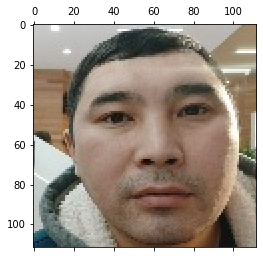

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0146.jpg
confidence =  0.92661625
blink =  1.172168e-06
const_left =  6
const_right =  7




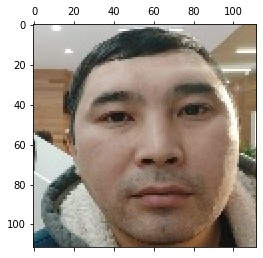

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0145.jpg
confidence =  0.92508316
blink =  1.0387092e-06
const_left =  7
const_right =  7




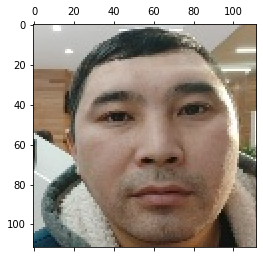

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0144.jpg
confidence =  0.90404385
blink =  1.8896081e-06
const_left =  6
const_right =  6




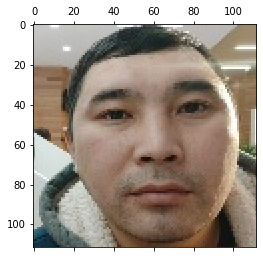

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0143.jpg
confidence =  0.90329146
blink =  7.157004e-07
const_left =  6
const_right =  6




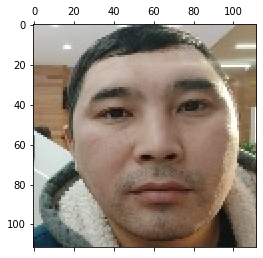

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0142.jpg
confidence =  0.8886242
blink =  7.021716e-07
const_left =  6
const_right =  7




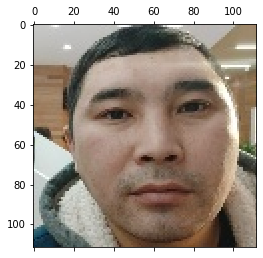

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0141.jpg
confidence =  0.8765364
blink =  8.8655764e-07
const_left =  6
const_right =  6




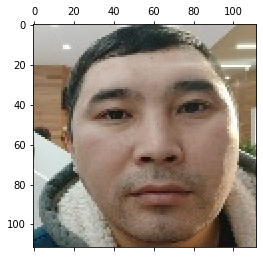

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0140.jpg
confidence =  0.9010574
blink =  5.448378e-07
const_left =  6
const_right =  6




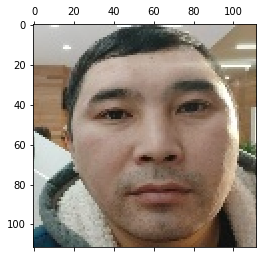

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0139.jpg
confidence =  0.8617572
blink =  1.4756243e-06
const_left =  6
const_right =  7




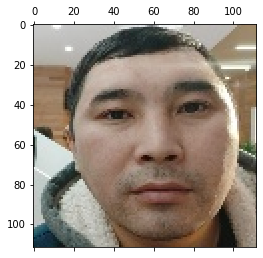

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0138.jpg
confidence =  0.7553408
blink =  1.4448989e-06
const_left =  5
const_right =  7




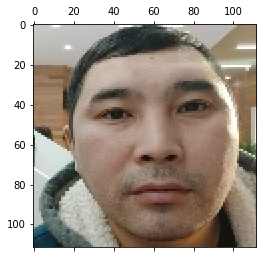

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0137.jpg
confidence =  0.88271827
blink =  9.711047e-07
const_left =  6
const_right =  6




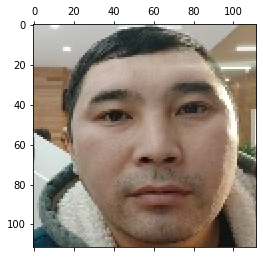

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0136.jpg
confidence =  0.8932016
blink =  8.5035543e-07
const_left =  6
const_right =  7




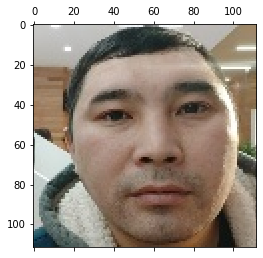

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0135.jpg
confidence =  0.90265226
blink =  6.040515e-07
const_left =  6
const_right =  7




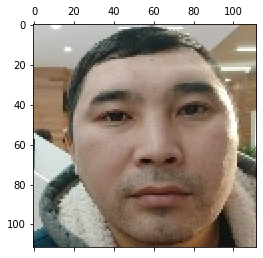

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0134.jpg
confidence =  0.93543273
blink =  7.957776e-07
const_left =  6
const_right =  7




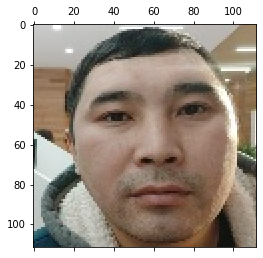

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0133.jpg
confidence =  0.88952625
blink =  1.6288359e-06
const_left =  5
const_right =  7




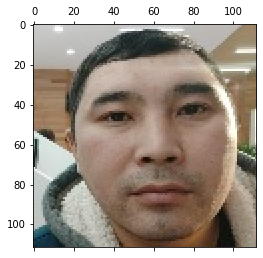

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0132.jpg
confidence =  0.8740592
blink =  2.1783146e-06
const_left =  6
const_right =  7




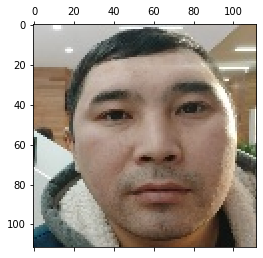

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0131.jpg
confidence =  0.9245266
blink =  6.313042e-07
const_left =  6
const_right =  7




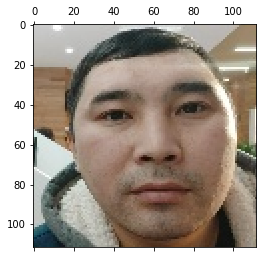

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0130.jpg
confidence =  0.8954781
blink =  5.223509e-07
const_left =  6
const_right =  7




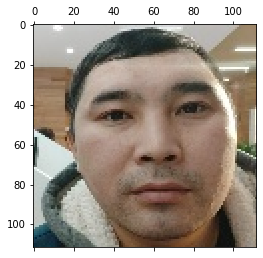

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0129.jpg
confidence =  0.8859158
blink =  7.5907997e-07
const_left =  6
const_right =  7




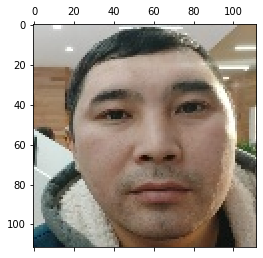

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0128.jpg
confidence =  0.8885163
blink =  9.1183534e-07
const_left =  6
const_right =  7




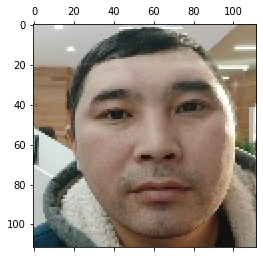

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0127.jpg
confidence =  0.90865725
blink =  1.0600711e-06
const_left =  6
const_right =  7




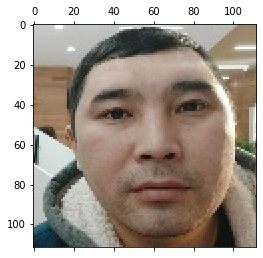

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0126.jpg
confidence =  0.77816164
blink =  1.7680877e-06
const_left =  5
const_right =  7




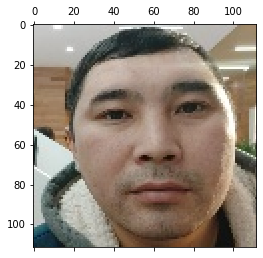

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0125.jpg
confidence =  0.9012284
blink =  1.0505685e-06
const_left =  5
const_right =  6




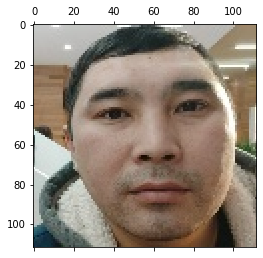

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0124.jpg
confidence =  0.8615332
blink =  1.0703086e-06
const_left =  6
const_right =  7




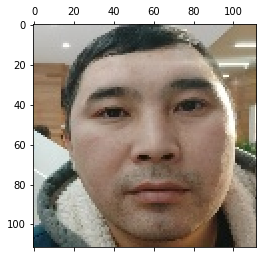

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0123.jpg
confidence =  0.8617495
blink =  1.0296612e-06
const_left =  5
const_right =  6




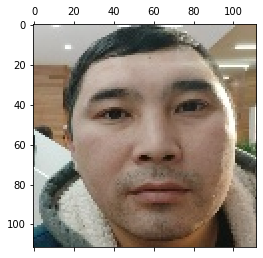

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0122.jpg
confidence =  0.8565947
blink =  1.9288427e-06
const_left =  6
const_right =  7




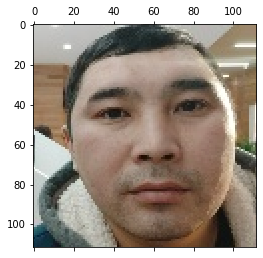

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0121.jpg
confidence =  0.8495413
blink =  5.27566e-07
const_left =  6
const_right =  5




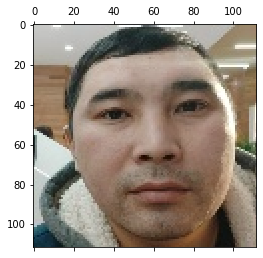

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0120.jpg
confidence =  0.8605793
blink =  1.5702217e-06
const_left =  6
const_right =  7




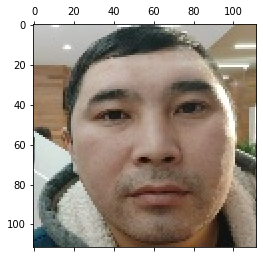

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0119.jpg
confidence =  0.8285683
blink =  9.988017e-07
const_left =  6
const_right =  7




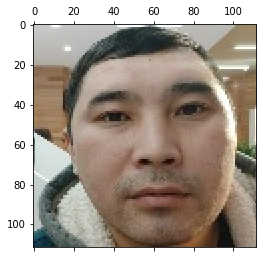

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0118.jpg
confidence =  0.86555994
blink =  1.3697628e-06
const_left =  6
const_right =  6




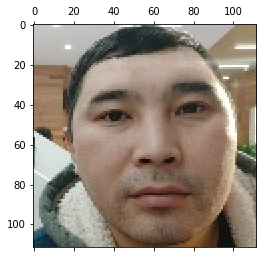

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0117.jpg
confidence =  0.8767182
blink =  5.119742e-07
const_left =  6
const_right =  7




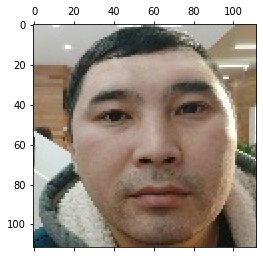

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0116.jpg
confidence =  0.8762079
blink =  8.666303e-07
const_left =  6
const_right =  7




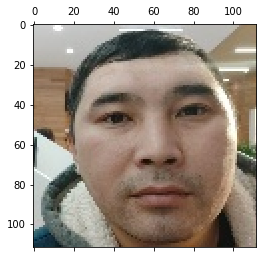

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0115.jpg
confidence =  0.9121648
blink =  1.4046495e-06
const_left =  6
const_right =  7




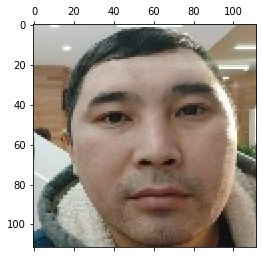

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0114.jpg
confidence =  0.74530584
blink =  1.6235274e-06
const_left =  6
const_right =  7




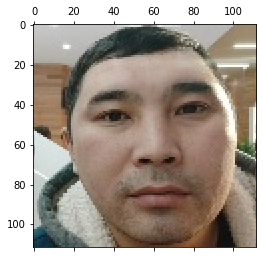

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0113.jpg
confidence =  0.8688496
blink =  1.2727731e-06
const_left =  6
const_right =  7




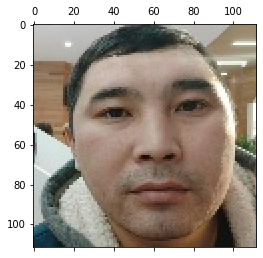

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0112.jpg
confidence =  0.8605087
blink =  1.0719891e-06
const_left =  6
const_right =  6




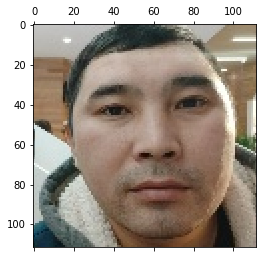

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0111.jpg
confidence =  0.74004084
blink =  1.8748262e-06
const_left =  6
const_right =  7




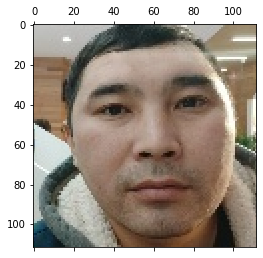

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0110.jpg
confidence =  0.7498053
blink =  1.4668049e-06
const_left =  6
const_right =  7




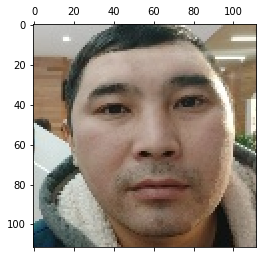

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0109.jpg
confidence =  0.755921
blink =  2.3889197e-06
const_left =  6
const_right =  6




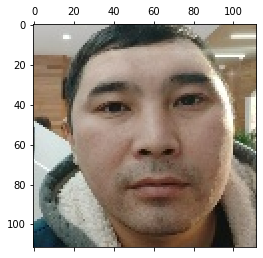

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0108.jpg
confidence =  0.7026736
blink =  2.1886806e-06
const_left =  6
const_right =  8




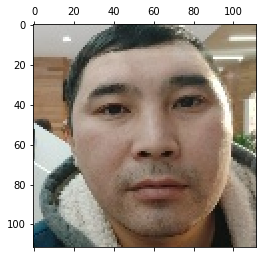

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0107.jpg
confidence =  0.77628726
blink =  3.4487325e-06
const_left =  6
const_right =  6




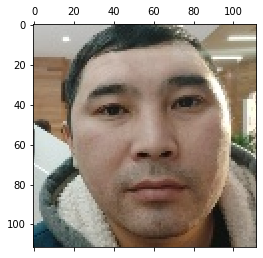

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0106.jpg
confidence =  0.7356815
blink =  6.8081804e-06
const_left =  6
const_right =  7




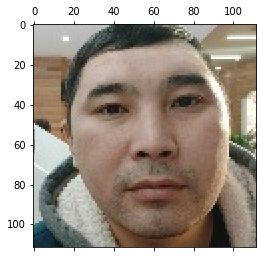

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0105.jpg
confidence =  0.70357734
blink =  6.009314e-06
const_left =  6
const_right =  7




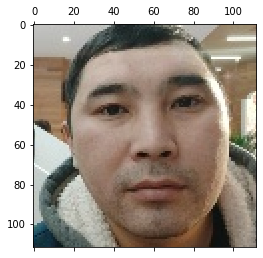

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0104.jpg
confidence =  0.68712807
blink =  7.795856e-06
const_left =  6
const_right =  6




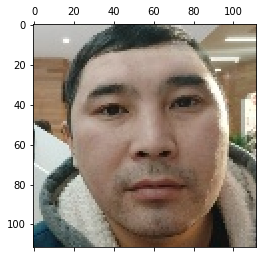

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0103.jpg
confidence =  0.7468512
blink =  8.041089e-06
const_left =  6
const_right =  7




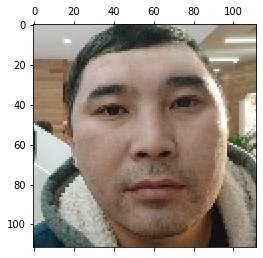

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0102.jpg
confidence =  0.6477755
blink =  1.2242288e-05
const_left =  6
const_right =  7




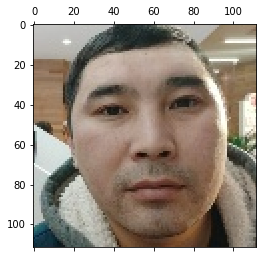

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0101.jpg
confidence =  0.8072939
blink =  1.529314e-05
const_left =  5
const_right =  7




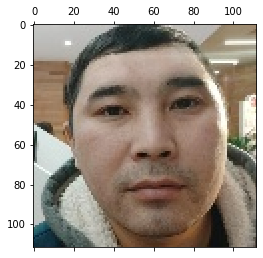

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0100.jpg
confidence =  0.6965862
blink =  6.0321895e-06
const_left =  6
const_right =  6




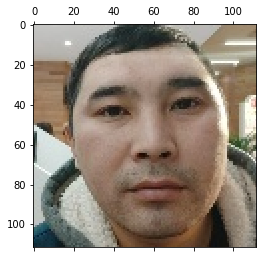

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0099.jpg
confidence =  0.7420207
blink =  9.259251e-06
const_left =  6
const_right =  7




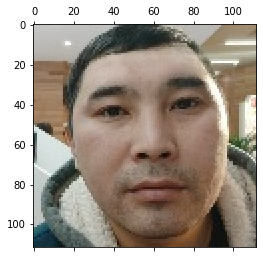

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0098.jpg
confidence =  0.91604275
blink =  2.2067136e-06
const_left =  6
const_right =  7




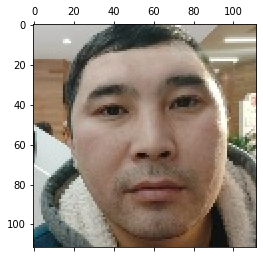

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0097.jpg
confidence =  0.8921349
blink =  5.3293197e-06
const_left =  5
const_right =  7




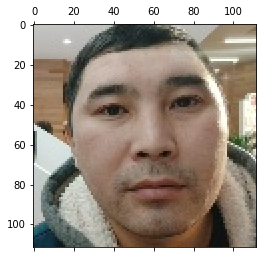

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0096.jpg
confidence =  0.6798463
blink =  1.0465691e-05
const_left =  6
const_right =  8




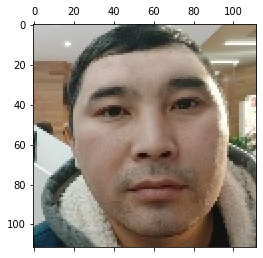

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0095.jpg
confidence =  0.8085099
blink =  2.3009957e-06
const_left =  6
const_right =  7




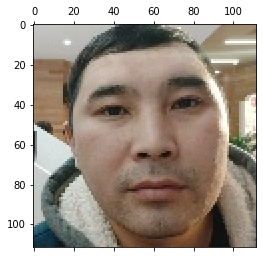

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0094.jpg
confidence =  0.70608795
blink =  1.6264177e-05
const_left =  5
const_right =  7




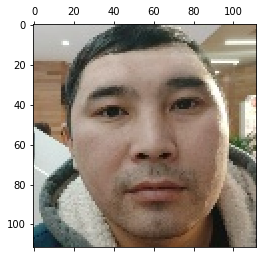

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0093.jpg
confidence =  0.8448835
blink =  5.5231226e-06
const_left =  6
const_right =  7




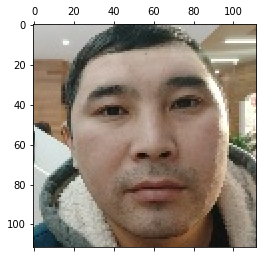

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0092.jpg
confidence =  0.8418946
blink =  1.1088789e-05
const_left =  5
const_right =  7




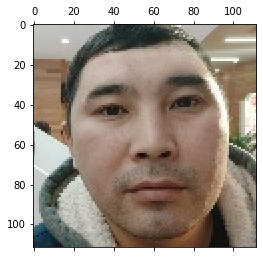

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0091.jpg
confidence =  0.90939814
blink =  4.3789446e-06
const_left =  6
const_right =  7




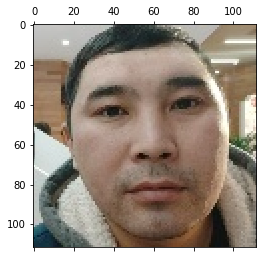

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0090.jpg
confidence =  0.84298784
blink =  7.794258e-06
const_left =  6
const_right =  8




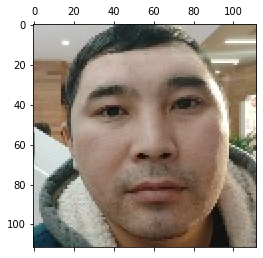

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0089.jpg
confidence =  0.8952162
blink =  2.3598095e-06
const_left =  6
const_right =  7




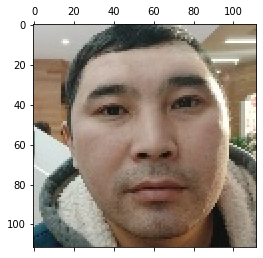

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0088.jpg
confidence =  0.8397819
blink =  1.1131626e-05
const_left =  6
const_right =  7




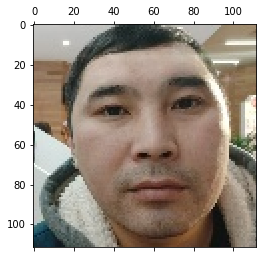

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0087.jpg
confidence =  0.80479044
blink =  7.625347e-06
const_left =  7
const_right =  7




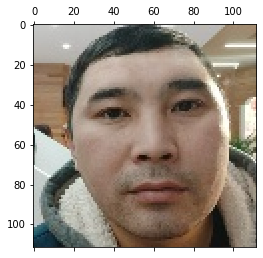

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0086.jpg
confidence =  0.7437058
blink =  5.083558e-06
const_left =  6
const_right =  5




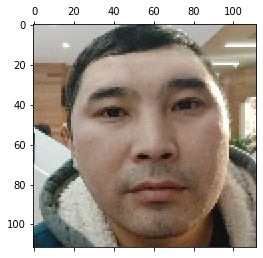

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0085.jpg
confidence =  0.71841824
blink =  5.8439127e-06
const_left =  6
const_right =  7




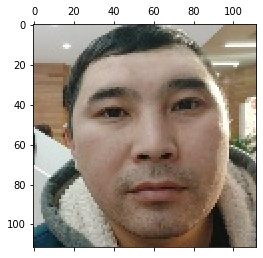

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0084.jpg
confidence =  0.70660424
blink =  1.0757623e-05
const_left =  5
const_right =  7




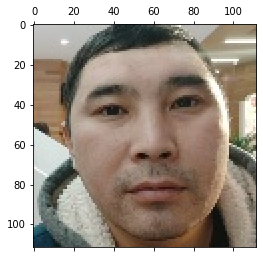

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0083.jpg
confidence =  0.9083743
blink =  5.408791e-06
const_left =  6
const_right =  7




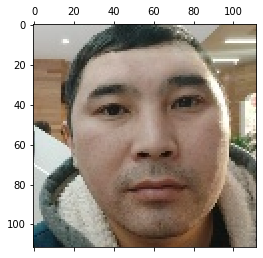

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0082.jpg
confidence =  0.83835894
blink =  8.62402e-06
const_left =  6
const_right =  7




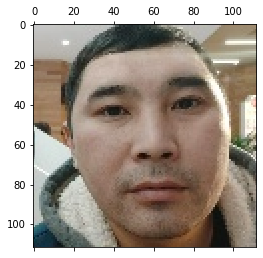

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0081.jpg
confidence =  0.71288663
blink =  7.84597e-06
const_left =  6
const_right =  7




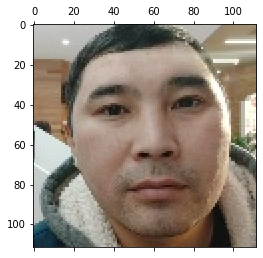

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0080.jpg
confidence =  0.74553704
blink =  7.083039e-06
const_left =  6
const_right =  7




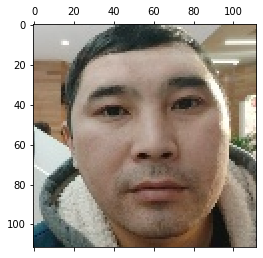

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0079.jpg
confidence =  0.7089075
blink =  5.222929e-06
const_left =  6
const_right =  7




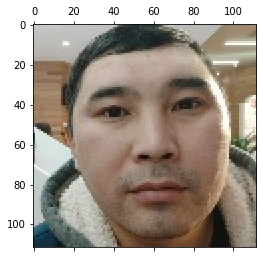

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0078.jpg
confidence =  0.9086549
blink =  1.3107829e-06
const_left =  6
const_right =  8




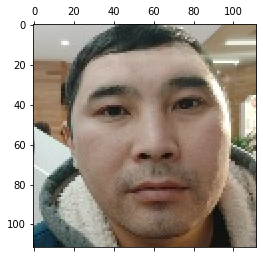

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0077.jpg
confidence =  0.7145312
blink =  4.5120437e-06
const_left =  7
const_right =  6




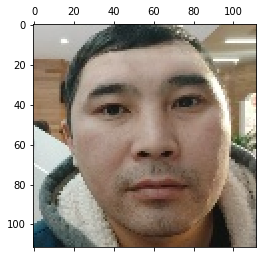

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0076.jpg
confidence =  0.7569717
blink =  2.9479856e-06
const_left =  6
const_right =  7




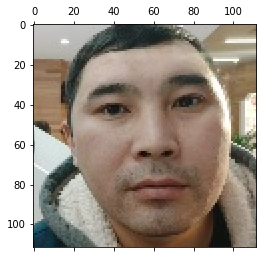

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0075.jpg
confidence =  0.7561074
blink =  3.9048914e-06
const_left =  7
const_right =  8




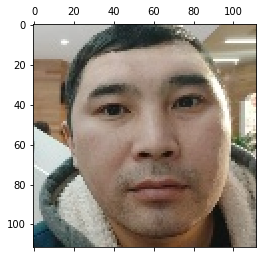

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0074.jpg
confidence =  0.8408987
blink =  3.0340611e-06
const_left =  6
const_right =  8




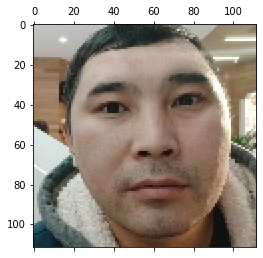

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0073.jpg
confidence =  0.844325
blink =  2.7360325e-06
const_left =  6
const_right =  8




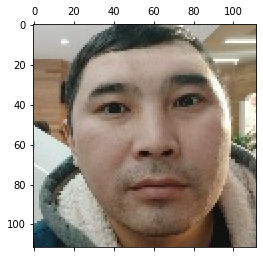

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0072.jpg
confidence =  0.7968154
blink =  3.0232873e-06
const_left =  8
const_right =  7




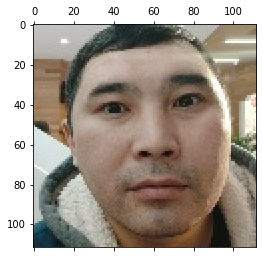

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0071.jpg
confidence =  0.7555532
blink =  2.3102396e-06
const_left =  8
const_right =  8




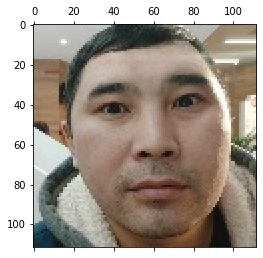

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0070.jpg
confidence =  0.7995491
blink =  2.8917e-06
const_left =  8
const_right =  8




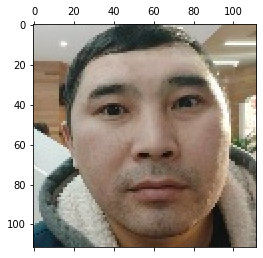

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0069.jpg
confidence =  0.76174915
blink =  2.2370095e-06
const_left =  7
const_right =  7




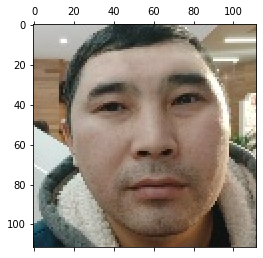

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0068.jpg
confidence =  0.90016335
blink =  4.061133e-06
const_left =  7
const_right =  7




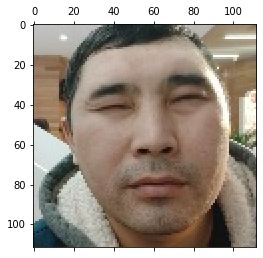

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0067.jpg
confidence =  0.36216483
blink =  0.76476866
const_left =  3
const_right =  4




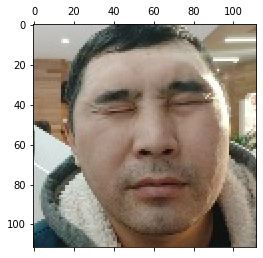

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0066.jpg
confidence =  0.0
blink =  0.9326177
const_left =  2
const_right =  3




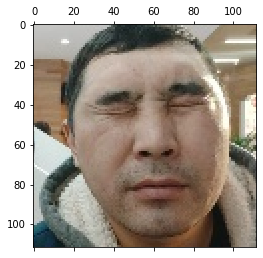

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0065.jpg
confidence =  0.64404255
blink =  0.58308303
const_left =  4
const_right =  5




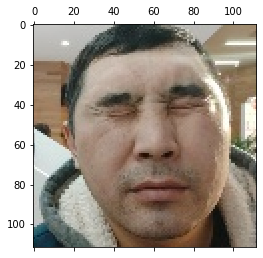

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0064.jpg
confidence =  0.6668715
blink =  0.58235335
const_left =  5
const_right =  5




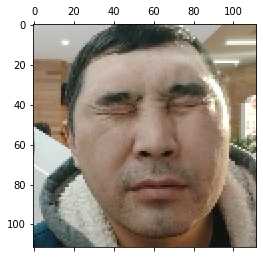

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0063.jpg
confidence =  0.7110542
blink =  0.37000263
const_left =  4
const_right =  5




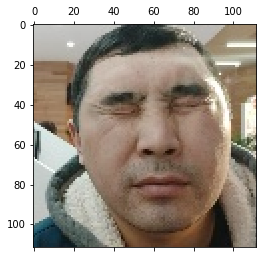

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0062.jpg
confidence =  0.59812057
blink =  0.28672597
const_left =  5
const_right =  5




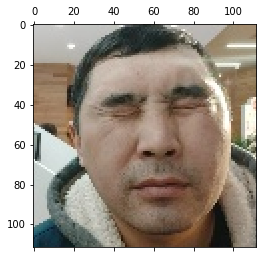

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0061.jpg
confidence =  0.5858315
blink =  0.45239508
const_left =  5
const_right =  5




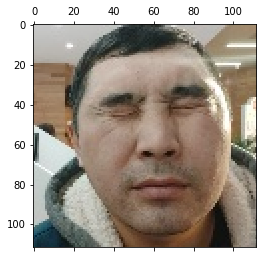

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0060.jpg
confidence =  0.5937336
blink =  0.51237375
const_left =  5
const_right =  5




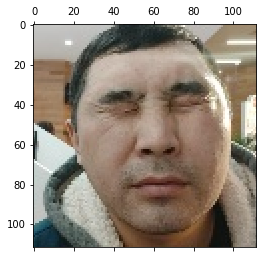

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0059.jpg
confidence =  0.5205359
blink =  0.4497098
const_left =  6
const_right =  6




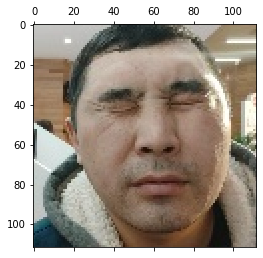

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0058.jpg
confidence =  0.5419801
blink =  0.64026004
const_left =  4
const_right =  5




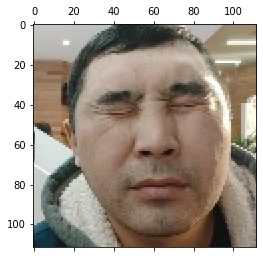

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0057.jpg
confidence =  0.54126453
blink =  0.5511433
const_left =  5
const_right =  5




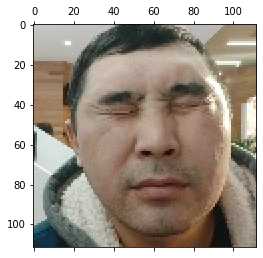

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0056.jpg
confidence =  0.3961625
blink =  0.8397353
const_left =  3
const_right =  5




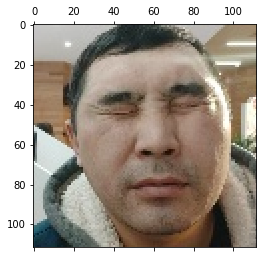

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0055.jpg
confidence =  0.4353064
blink =  0.7302811
const_left =  3
const_right =  5




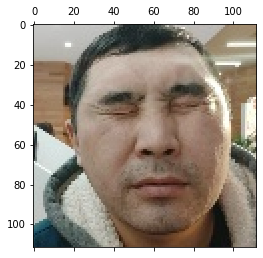

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0054.jpg
confidence =  0.43206537
blink =  0.6185116
const_left =  3
const_right =  4




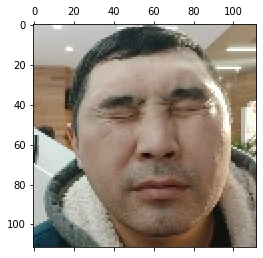

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0053.jpg
confidence =  0.75542796
blink =  0.37920427
const_left =  3
const_right =  4




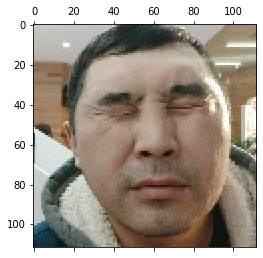

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0052.jpg
confidence =  0.5761772
blink =  0.7398023
const_left =  5
const_right =  5




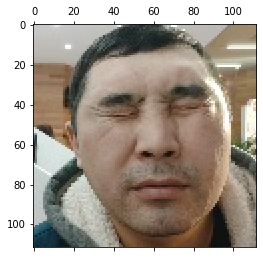

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0051.jpg
confidence =  0.61440915
blink =  0.55795634
const_left =  3
const_right =  4




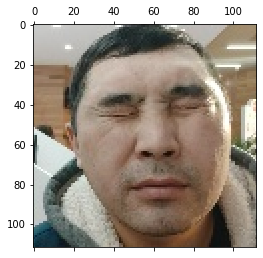

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0050.jpg
confidence =  0.5387337
blink =  0.53647834
const_left =  3
const_right =  4




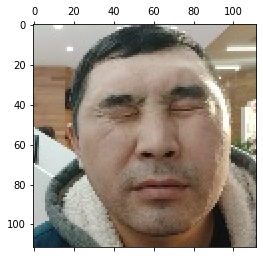

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0049.jpg
confidence =  0.5994299
blink =  0.59649634
const_left =  4
const_right =  4




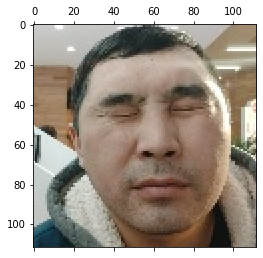

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0048.jpg
confidence =  0.0
blink =  0.960132
const_left =  3
const_right =  4




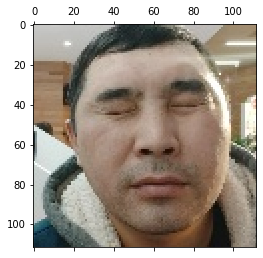

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0047.jpg
confidence =  0.0
blink =  0.9799969
const_left =  1
const_right =  2




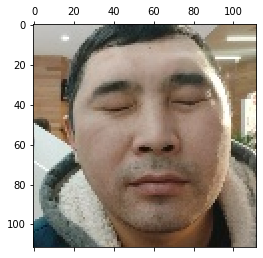

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0046.jpg
confidence =  0.0
blink =  0.9999989
const_left =  0
const_right =  2




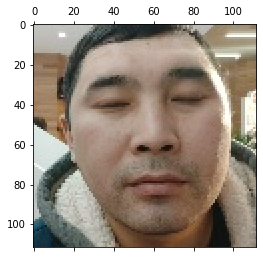

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0045.jpg
confidence =  0.0
blink =  0.99998176
const_left =  2
const_right =  2




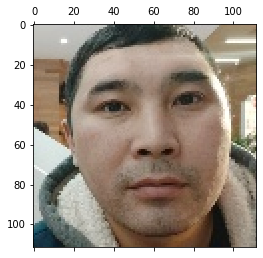

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0044.jpg
confidence =  0.8689481
blink =  1.615781e-06
const_left =  7
const_right =  7




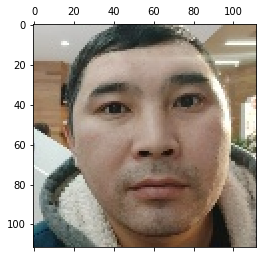

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0043.jpg
confidence =  0.7954349
blink =  4.924636e-06
const_left =  8
const_right =  8




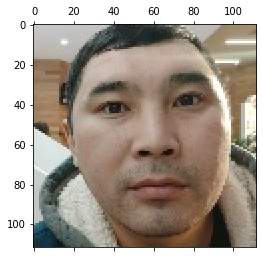

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0042.jpg
confidence =  0.7641654
blink =  2.551572e-06
const_left =  8
const_right =  7




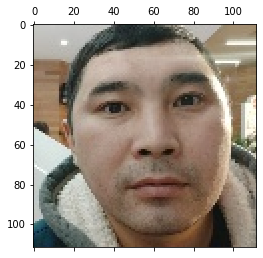

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0041.jpg
confidence =  0.8816423
blink =  1.1548407e-06
const_left =  6
const_right =  7




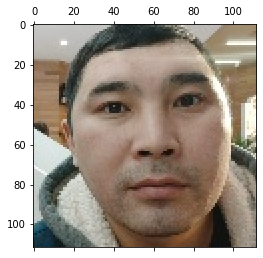

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0040.jpg
confidence =  0.74231255
blink =  2.4727358e-06
const_left =  7
const_right =  7




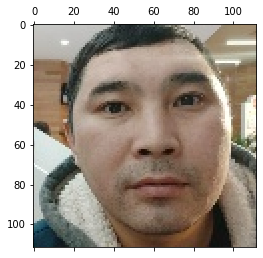

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0039.jpg
confidence =  0.88123226
blink =  3.2170633e-06
const_left =  7
const_right =  7




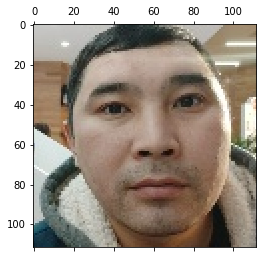

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0038.jpg
confidence =  0.8141496
blink =  2.3792002e-06
const_left =  8
const_right =  8




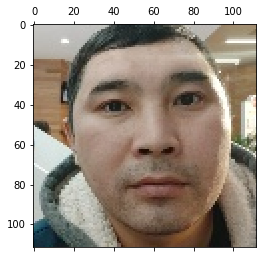

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0037.jpg
confidence =  0.78506076
blink =  2.5538404e-06
const_left =  8
const_right =  7




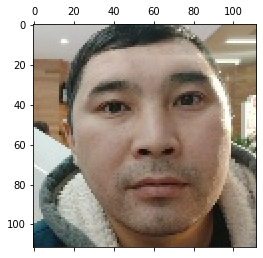

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0036.jpg
confidence =  0.8828683
blink =  1.3558719e-06
const_left =  7
const_right =  8




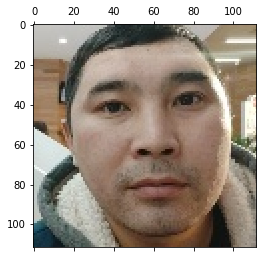

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0035.jpg
confidence =  0.8533788
blink =  2.2447714e-06
const_left =  7
const_right =  8




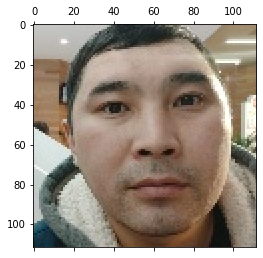

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0034.jpg
confidence =  0.87937814
blink =  1.285462e-06
const_left =  6
const_right =  7




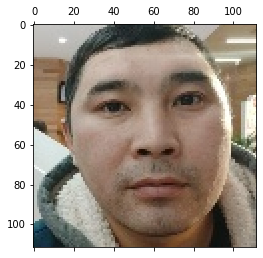

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0033.jpg
confidence =  0.8478191
blink =  3.0363133e-06
const_left =  7
const_right =  8




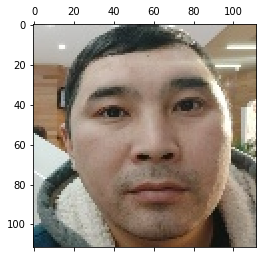

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0032.jpg
confidence =  0.9125089
blink =  1.5181176e-06
const_left =  7
const_right =  7




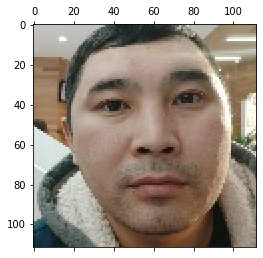

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0031.jpg
confidence =  0.7802536
blink =  1.9951558e-06
const_left =  7
const_right =  7




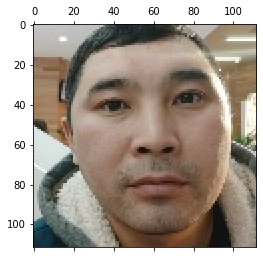

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0030.jpg
confidence =  0.7951651
blink =  1.7610802e-06
const_left =  6
const_right =  7




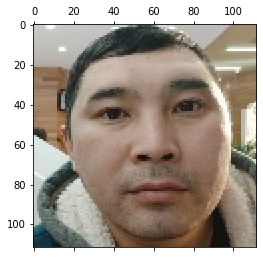

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0029.jpg
confidence =  0.8870804
blink =  8.3769737e-07
const_left =  7
const_right =  7




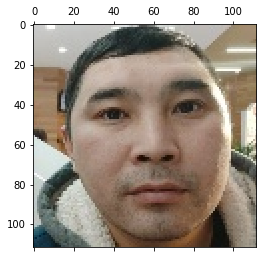

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0028.jpg
confidence =  0.8873688
blink =  1.5559591e-06
const_left =  7
const_right =  7




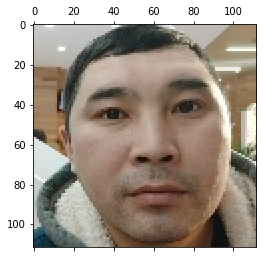

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0027.jpg
confidence =  0.9011478
blink =  1.4330054e-06
const_left =  6
const_right =  7




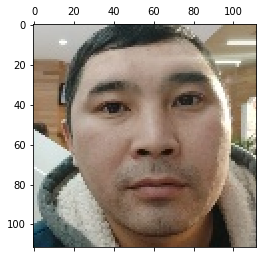

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0026.jpg
confidence =  0.90328985
blink =  1.2899001e-06
const_left =  6
const_right =  7




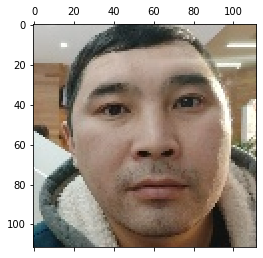

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0025.jpg
confidence =  0.7791658
blink =  2.5288725e-06
const_left =  6
const_right =  7




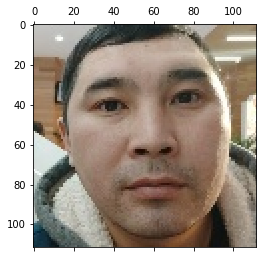

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0024.jpg
confidence =  0.8974356
blink =  5.2494914e-07
const_left =  7
const_right =  8




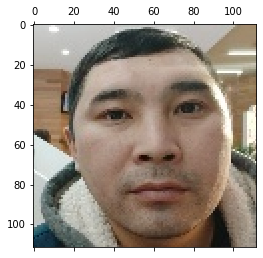

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0023.jpg
confidence =  0.89385164
blink =  2.6684068e-06
const_left =  7
const_right =  8




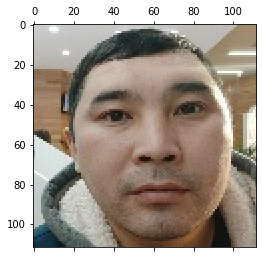

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0022.jpg
confidence =  0.8472751
blink =  1.1368054e-06
const_left =  6
const_right =  7




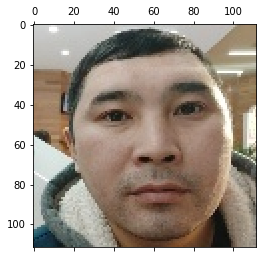

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0021.jpg
confidence =  0.8982943
blink =  1.8131799e-06
const_left =  7
const_right =  7




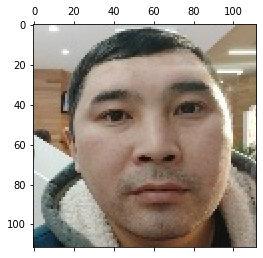

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0020.jpg
confidence =  0.91701317
blink =  5.155666e-07
const_left =  6
const_right =  8




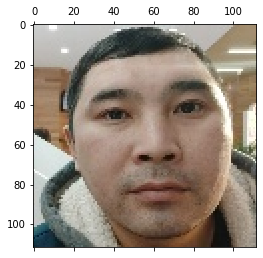

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0019.jpg
confidence =  0.8256448
blink =  1.3395351e-06
const_left =  6
const_right =  7




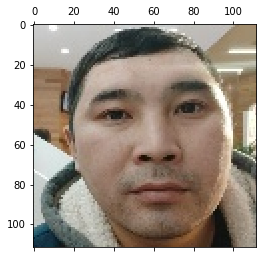

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0018.jpg
confidence =  0.7960331
blink =  2.3195892e-06
const_left =  7
const_right =  8




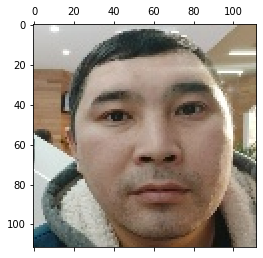

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0017.jpg
confidence =  0.8499163
blink =  8.842466e-07
const_left =  7
const_right =  7




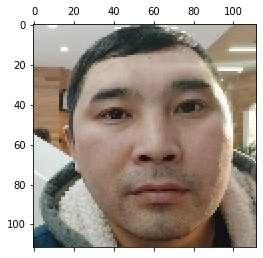

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0016.jpg
confidence =  0.8646238
blink =  1.7594099e-06
const_left =  6
const_right =  7




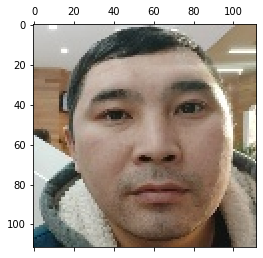

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0015.jpg
confidence =  0.78993946
blink =  1.7927754e-06
const_left =  7
const_right =  8




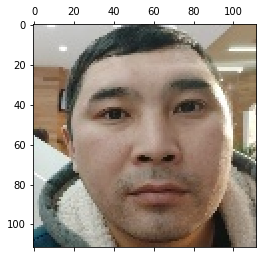

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0014.jpg
confidence =  0.8307257
blink =  1.5092197e-06
const_left =  7
const_right =  7




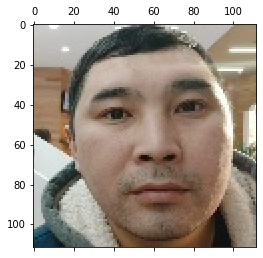

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0013.jpg
confidence =  0.7612353
blink =  2.536232e-06
const_left =  7
const_right =  7




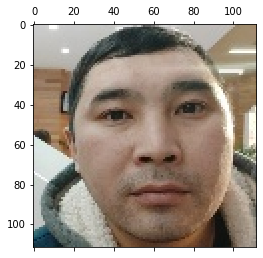

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0012.jpg
confidence =  0.86319965
blink =  8.3510974e-07
const_left =  7
const_right =  7




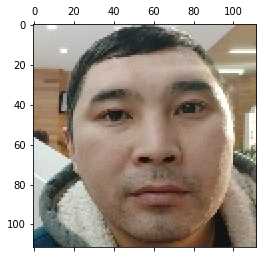

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0011.jpg
confidence =  0.89527917
blink =  5.857622e-07
const_left =  6
const_right =  7




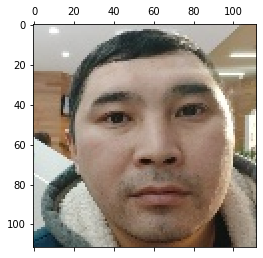

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0010.jpg
confidence =  0.87459975
blink =  9.169166e-07
const_left =  6
const_right =  8




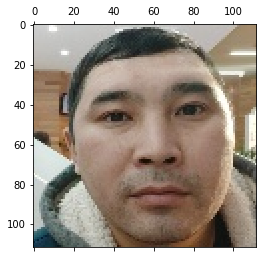

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0009.jpg
confidence =  0.79068714
blink =  8.116617e-07
const_left =  6
const_right =  8




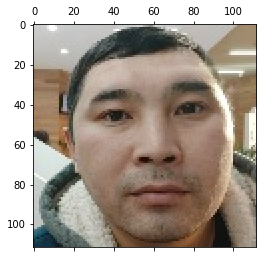

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0008.jpg
confidence =  0.8799674
blink =  5.5473345e-07
const_left =  6
const_right =  7




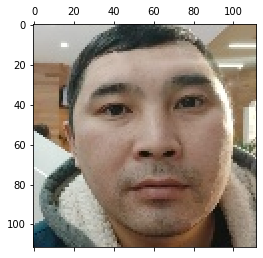

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0007.jpg
confidence =  0.78383803
blink =  1.7122487e-06
const_left =  6
const_right =  7




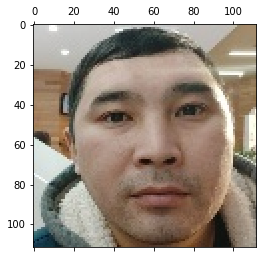

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0006.jpg
confidence =  0.9175959
blink =  4.5118057e-07
const_left =  7
const_right =  8




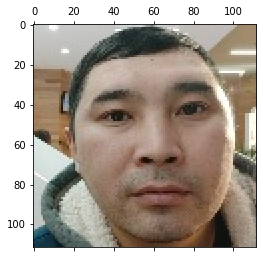

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0005.jpg
confidence =  0.8720796
blink =  6.1100576e-07
const_left =  7
const_right =  7




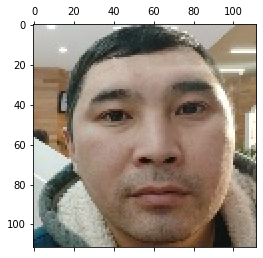

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0004.jpg
confidence =  0.8538028
blink =  7.852279e-07
const_left =  6
const_right =  8




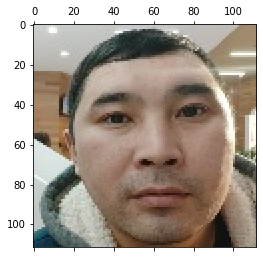

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0003.jpg
confidence =  0.89276016
blink =  8.554619e-07
const_left =  6
const_right =  7




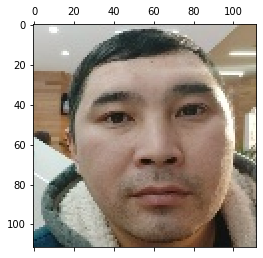

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0002.jpg
confidence =  0.8906618
blink =  1.1901218e-06
const_left =  6
const_right =  8




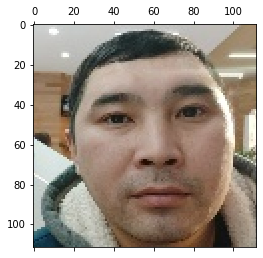

/mnt/data/frames/altyn_original_fps_igor_origami_extended_0003_112/62d4d1ae-9851-48ec-816f-a77f4f7d7a27/0001.jpg
confidence =  0.74345857
blink =  3.7795355e-06
const_left =  7
const_right =  8




In [20]:
for i,row in (df_test_new[df_test_new['person_id']=='62d4d1ae-9851-48ec-816f-a77f4f7d7a27']).sort_values(by=['frame_num'], ascending=False).iterrows():

    file = row['file']
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.matshow(img)
    plt.show()
    print(row['file'])
    #print('object =', row['object'])
    #print('low_resolution =', row['low_resolution'])
    print('confidence = ', row['confidence'])
    print('blink = ', row['blink'])
    print('const_left = ', row['const_left'])
    print('const_right = ', row['const_right'])
    print('\n')

In [ ]:
#Пробуем через blink находить смену с открытого глаза на закрытый и оставляем только кадры из этих интервалов
"""df = pd.DataFrame(data=None, columns=list(df_test.columns.values))

appending = False
for index, row in df_test[:10].iterrows():
    person_id = row['person_id']
    file = row['file']
    blink = row['blink']
    const_left = row['const_left']
    const_right = row['const_right']

    if blink
    if appending:
        df.loc[index] = row
df"""

file     blink  bounding_box  \
1   /mnt/data/frames/altyn_original_fps_igor_origa...  0.000002  14,26,98,110   
2   /mnt/data/frames/altyn_original_fps_igor_origa...  0.000003  13,27,97,111   
3   /mnt/data/frames/altyn_original_fps_igor_origa...  0.000003  14,26,97,109   
5   /mnt/data/frames/altyn_original_fps_igor_origa...  0.000011  13,28,95,110   
6   /mnt/data/frames/altyn_original_fps_igor_origa...  0.000007  14,26,97,109   
7   /mnt/data/frames/altyn_original_fps_igor_origa...  0.000007  14,26,97,109   
8   /mnt/data/frames/altyn_original_fps_igor_origa...  0.000007  14,25,98,109   
12  /mnt/data/frames/altyn_original_fps_igor_origa...  0.000003  14,25,98,110   
13  /mnt/data/frames/altyn_original_fps_igor_origa...  0.000003  14,26,98,109   
15  /mnt/data/frames/altyn_original_fps_igor_origa...  0.000005  13,25,97,110   

   bounding_box_center_x bounding_box_center_x_deviation  \
1                     56                             0.0   
2                     55                       -0.008929   
3                     55                       -0.004464   
5                     54                       -0.017857   
6                     55                       -0.004464   
7                     55                       -0.004464   
8                     56                             0.0   
12                    56                             0.0   
13                    56                             0.0   
15                    55                       -0.008929   

   bounding_box_center_y bounding_box_center_y_deviation bounding_box_height  \
1                     68                        0.107143                  84   
2                     69                        0.116071                  84   
3                     67                        0.102679                  83   
5                     69                        0.116071                  82   
6                     67                        0.102679                  83   
7                     67                        0.102679                  83   
8                     67                        0.098214                  84   
12                    67                        0.102679                  85   
13                    67                        0.102679                  83   
15                    67                        0.102679                  85   

   bounding_box_height_relative bounding_box_width  ... light_lighting  \
1                          0.75                 84  ...       0.138742   
2                          0.75                 84  ...        0.11614   
3                      0.741071                 83  ...       0.088437   
5                      0.732143                 82  ...       0.182376   
6                      0.741071                 83  ...       0.082775   
7                      0.741071                 83  ...       0.094704   
8                          0.75                 84  ...       0.124834   
12                     0.758929                 84  ...       0.156042   
13                     0.741071                 84  ...       0.129816   
15                     0.758929                 84  ...       0.108338   

   num_of_all_faces    object sharpness     smile   up_down width const_left  \
1                 1  0.000339    0.6875  0.000292  0.214286   112       0.28   
2                 1  0.000401      0.75  0.000337  0.214286   112       0.29   
3                 1  0.000548    0.6875  0.000237  0.228916   112       0.31   
5                 1  0.002567    0.6875  0.000369  0.219512   112       0.26   
6                 1  0.000317    0.6875  0.000229  0.228916   112       0.26   
7                 1  0.000444    0.6875  0.000236  0.228916   112       0.28   
8                 1  0.000386    0.6875  0.000344  0.238095   112       0.26   
12                1  0.000717    0.6875  0.000326  0.223529   112       0.27   
13                1  0.000688      0.75  0.000314  0.228916   112       0.28   
